In [2]:
import cv2
import numpy as np

# --- Cargar y preparar imagen ---
img = cv2.imread('monedas.jpg')
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
pimg = cv2.medianBlur(gris, 7)


circ = cv2.HoughCircles(
    pimg,
    cv2.HOUGH_GRADIENT,
    1,
    100,
    param1=100,
    param2=50,
    minRadius=50,
    maxRadius=150,
)

if circ is None:
    print("No se detectaron círculos.")
    exit()

# --- Preparación de imágenes ---
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_cont = np.zeros(img_rgb.shape, dtype=np.uint8)

# --- Datos de referencia Calculados como diamtreo-1-euro/diametro-x---
proportions = {
    1.43: '1cent',
    1.24: '2cent',
    1.09: '5cent',
    1.18: '10cent',
    1.04: '20cent',
    0.96: '50cent',
    0.90: '2eur'
}
# Diccioanrio con el nombre de las monedas y su valor
coin_values = {
    '1cent': 0.01,
    '2cent': 0.02,
    '5cent': 0.05,
    '10cent': 0.10,
    '20cent': 0.20,
    '50cent': 0.50,
    '1eur': 1.00,
    '2eur': 2.00
}

reference_diameter = None

# --- Función buscadora ---
def buscar_mas_cercano(dic, valor):
    clave_mas_cercana = min(dic.keys(), key=lambda k: abs(k - valor))
    return dic[clave_mas_cercana]


def mouse_click(event, x, y, flags, param):
    global reference_diameter

    if event == cv2.EVENT_LBUTTONDOWN:
        coins = param["coins"]
        proportions = param["proportions"]

        # Buscar moneda clicada
        coin_clicked = None
        for (cx, cy, r) in coins:
            if (x - cx)**2 + (y - cy)**2 <= r**2:
                coin_clicked = (cx, cy, r)
                break

        if coin_clicked is None:
            print("No se detectó ninguna moneda en el clic.")
            return

        # Guardar diámetro de referencia
        reference_diameter = coin_clicked[-1] * 2
        print(f"Moneda seleccionada como referencia: diámetro = {reference_diameter:.2f}px")

        # --- Calcular todas las monedas ---
        total = 0
        resultados = []

        for (cx, cy, r) in coins:
            d = r * 2
            proportion = reference_diameter / d
            coin_name = buscar_mas_cercano(proportions, proportion)
            if(reference_diameter == d):
                coin_name = '1eur'
            valor = coin_values.get(coin_name, 0)
            total += valor
            resultados.append((cx, cy, r, coin_name, valor))
            print(f"Moneda detectada: {coin_name} ({valor:.2f}€)")

        print(f"\n TOTAL DETECTADO: {total:.2f} €")

        # Dibujar resultado
        output = img_rgb.copy()
        for (cx, cy, r, name, val) in resultados:
            cv2.circle(output, (int(cx), int(cy)), int(r), (0, 255, 0), 2)
            cv2.putText(output, f"{name}", (int(cx) - 40, int(cy)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        cv2.putText(output, f"TOTAL: {total:.2f} EUR", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

        cv2.imshow("Resultado", cv2.cvtColor(output, cv2.COLOR_RGB2BGR))

# --- Dibujar círculos detectados antes del clic ---
for (x, y, r) in circ[0]:
    cv2.circle(img_rgb, (int(x), int(y)), int(r), (0, 255, 0), 2)

cv2.imshow("Monedas detectadas", cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
cv2.setMouseCallback("Monedas detectadas", mouse_click, {"coins": circ[0], "proportions": proportions})

print(" Haz clic en la moneda de referencia 1€.")
print("El programa identificará automáticamente todas las demás monedas y mostrará el total.\n")

cv2.waitKey(0)
cv2.destroyAllWindows()


 Haz clic en la moneda de referencia 1€.
El programa identificará automáticamente todas las demás monedas y mostrará el total.

Moneda seleccionada como referencia: diámetro = 174.60px
Moneda detectada: 2eur (2.00€)
Moneda detectada: 50cent (0.50€)
Moneda detectada: 50cent (0.50€)
Moneda detectada: 1eur (1.00€)
Moneda detectada: 5cent (0.05€)
Moneda detectada: 5cent (0.05€)
Moneda detectada: 10cent (0.10€)
Moneda detectada: 2cent (0.02€)

 TOTAL DETECTADO: 4.22 €


Extrayendo características de entrenamiento...
 FRA -> 18 características extraídas
 PEL -> 18 características extraídas
 TAR -> 18 características extraídas

Entrenando clasificador Random Forest...

Clasificando partículas en la imagen de test...

MÉTRICAS DE CLASIFICACIÓN
Accuracy  : 0.608 (60.8%)
Precision : 0.602
Recall    : 0.608
F1-score  : 0.587


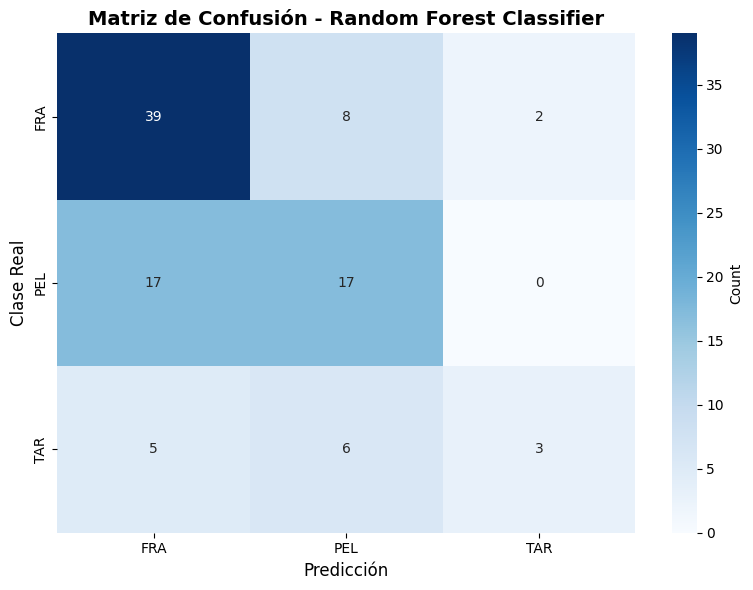

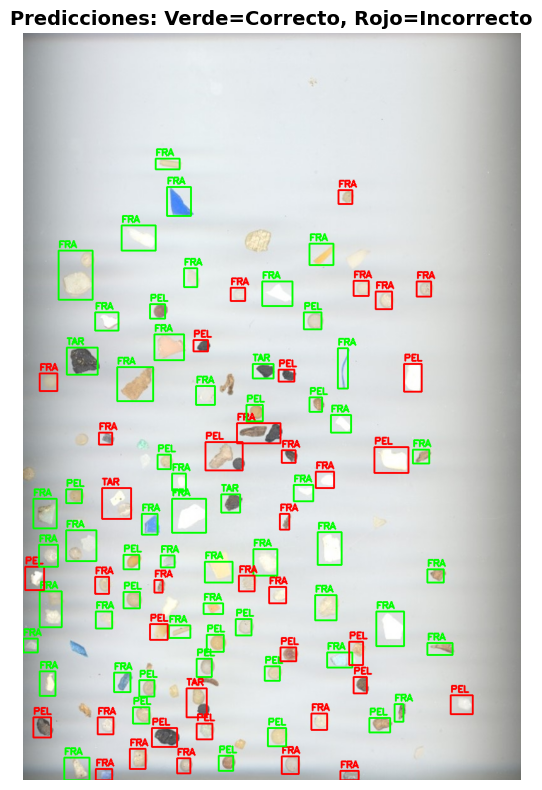

In [4]:
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

train_imgs = {
    "FRA": "FRA.png",
    "PEL": "PEL.png",
    "TAR": "TAR.png"
}

test_img_path = "MPs_test.jpg"
test_csv_path = "MPs_test_bbs.csv"

def extract_features(img):
    """Extract geometric and color features from particle image"""
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Thresholding
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    if np.mean(gray[mask == 255]) > np.mean(gray[mask == 0]):
        mask = cv2.bitwise_not(mask)
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    cnt = max(contours, key=cv2.contourArea)
    
    # Geometric features
    x, y, w, h = cv2.boundingRect(cnt)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    compacidad = (perimeter ** 2) / (area + 1e-9)
    rel_area_box = area / (w * h + 1e-9)
    aspect_ratio = w / (h + 1e-9)
    
    # Ellipse fit
    if len(cnt) >= 5:
        try:
            (_, _), (MA, ma), _ = cv2.fitEllipse(cnt)
            rel_ejes = MA / (ma + 1e-9)
        except:
            rel_ejes = 0
    else:
        rel_ejes = 0
    
    # Centroid and distance ratio
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0
    
    dists = [cv2.norm(np.array([cx, cy], dtype=np.float32) - p[0].astype(np.float32)) for p in cnt]
    rel_dist = min(dists) / (max(dists) + 1e-9) if len(dists) > 0 else 0
    
    # --- NEW: Color features ---
    # Extract masked region for color analysis
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    
    # Mean RGB values
    mean_b = np.mean(img[mask == 255, 0]) if np.any(mask == 255) else 0
    mean_g = np.mean(img[mask == 255, 1]) if np.any(mask == 255) else 0
    mean_r = np.mean(img[mask == 255, 2]) if np.any(mask == 255) else 0
    
    # Standard deviation of colors
    std_b = np.std(img[mask == 255, 0]) if np.any(mask == 255) else 0
    std_g = np.std(img[mask == 255, 1]) if np.any(mask == 255) else 0
    std_r = np.std(img[mask == 255, 2]) if np.any(mask == 255) else 0
    
    # HSV features
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mean_h = np.mean(hsv[mask == 255, 0]) if np.any(mask == 255) else 0
    mean_s = np.mean(hsv[mask == 255, 1]) if np.any(mask == 255) else 0
    mean_v = np.mean(hsv[mask == 255, 2]) if np.any(mask == 255) else 0
    
    # Solidity
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = area / (hull_area + 1e-9)
    
    # Extent
    extent = area / (w * h + 1e-9)
    
    return [
        area, perimeter, compacidad, rel_area_box, aspect_ratio, rel_ejes, rel_dist,
        mean_r, mean_g, mean_b, std_r, std_g, std_b,
        mean_h, mean_s, mean_v, solidity, extent
    ]


# --- Extract features from training images ---
print("Extrayendo características de entrenamiento...")
patterns = {}
X_train = []
y_train = []

for label, path in train_imgs.items():
    img = cv2.imread(path)
    if img is None:
        print(f"No se pudo cargar {path}")
        continue
    
    features = extract_features(img)
    if features is None:
        print(f"No se pudieron extraer características de {label}")
        continue
    
    patterns[label] = np.array(features)
    X_train.append(features)
    y_train.append(label)
    print(f" {label} -> {len(features)} características extraídas")

if len(patterns) < 3:
    raise RuntimeError("No se pudieron generar todos los patrones de referencia.")

# --- Normalize features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# --- Train Random Forest Classifier ---
print("\nEntrenando clasificador Random Forest...")
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
clf.fit(X_train_scaled, y_train)

# --- Classification on test image ---
print("\nClasificando partículas en la imagen de test...")

img_test = cv2.imread(test_img_path)
if img_test is None:
    raise FileNotFoundError(f"No se encontró la imagen {test_img_path}")

y_true = []
y_pred = []

# Read CSV and classify each particle
with open(test_csv_path, newline="") as file:
    reader = csv.DictReader(file)
    for row in reader:
        label = row["label"]
        x_min, y_min, x_max, y_max = map(int, [
            row["x_min"], row["y_min"], row["x_max"], row["y_max"]
        ])
        
        crop = img_test[y_min:y_max, x_min:x_max]
        features = extract_features(crop)
        
        if features is None:
            # Use most common class as fallback
            pred = "FRA"
        else:
            # Scale features and predict
            features_scaled = scaler.transform([features])
            pred = clf.predict(features_scaled)[0]
        
        y_true.append(label)
        y_pred.append(pred)

# --- Calculate metrics ---
print("\n" + "="*50)
print("MÉTRICAS DE CLASIFICACIÓN")
print("="*50)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy  : {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1-score  : {f1:.3f}")
print("="*50)


# --- Confusion Matrix ---
labels = ["FRA", "PEL", "TAR"]
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'})
plt.xlabel("Predicción", fontsize=12)
plt.ylabel("Clase Real", fontsize=12)
plt.title("Matriz de Confusión - Random Forest Classifier", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# --- Visualize predictions ---
colores = {"FRA": (0, 0, 255), "PEL": (0, 255, 0), "TAR": (255, 0, 0)}
img_display = img_test.copy()

with open(test_csv_path, newline="") as file:
    reader = csv.DictReader(file)
    for i, row in enumerate(reader):
        x_min, y_min, x_max, y_max = map(int, [
            row["x_min"], row["y_min"], row["x_max"], row["y_max"]
        ])
        pred = y_pred[i]
        true_label = y_true[i]
        
        # Color: green if correct, red if incorrect
        is_correct = (pred == true_label)
        color = (0, 255, 0) if is_correct else (0, 0, 255)
        
        cv2.rectangle(img_display, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(img_display, f"{pred}", (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Predicciones: Verde=Correcto, Rojo=Incorrecto", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()